In [ ]:
pip install scikit-learn-extra

In [ ]:
!pip install --quiet pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import sys
import time
import random
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from __future__ import division
import matplotlib.pyplot as plt
from numpy.linalg import norm
from sklearn.cluster import KMeans
# input = "/content/gdrive/My Drive/DataSet1/Country-data.csv"
input = "/content/gdrive/MyDrive/Big Data Project/customer_data.xlsx"

## Sequential K Means clustering

In [ ]:
# Import Python modules
from __future__ import division
import numpy as np
import sklearn.datasets as skl
import matplotlib.pyplot as plt
from multiprocessing import Pool
import timeit

class K_Means(object):
    # Initialize input values n_clusters and max_iter
    def __init__(self, n_clusters, max_iter):
        self.n_clusters = n_clusters
        self.max_iter = max_iter

    # Function that assigns points to a cluster
    def assign_points_to_cluster(self, X):
        # Label points according to the minimum euclidean distance
        self.labels_ = [self._nearest(self.cluster_centers_, x) for x in X]
        # Map labels to data points
        indices=[]
        for j in range(self.n_clusters):
            cluster=[]
            for i, l in enumerate(self.labels_):
                if l==j: cluster.append(i)
            indices.append(cluster)
        X_by_cluster = [X[i] for i in indices]
        return X_by_cluster

    # Function that randomly selects initial centroids
    def initial_centroid(self, X):
        initial = np.random.permutation(X.shape[0])[:self.n_clusters]
        return X[initial]

    # Function that updates centroids and repeats
    # assign_points_to_cluster until convergence or max_iter is reached
    def fit(self, X):
        # initialize centroids
        self.cluster_centers_ = self.initial_centroid(X)
        # process of assigning points to clusters until convergence or until max_iter is reached
        for i in range(self.max_iter):
            X_by_cluster = self.assign_points_to_cluster(X)
            # calculate the new centers
            new_centers=[c.sum(axis=0)/len(c) for c in X_by_cluster]
            new_centers = [arr.tolist() for arr in new_centers]
            old_centers=self.cluster_centers_
            # if the new centroid are the same as the old centroids then the algorithm has converged
            if np.all(new_centers == old_centers):
                self.number_of_iter=i
                break;
            else:
                # set self.cluster_centers_ as new centers
                self.cluster_centers_ = new_centers
        self.number_of_iter=i
        return self
    # Function that calculates the minimum euclidean distance
    def _nearest(self, clusters, x):
        return np.argmin([self._distance(x, c) for c in clusters])

    # Function to calculate euclidean distance between two points
    def _distance(self, a, b):
        return np.sqrt(((a - b)**2).sum())

    # Function that returns predicted clusters for each point
    def predict(self, X):
      return self.labels_



# Example usage:
# k_medoids = K_Medoids(n_clusters=3, max_iter=100)
# k_medoids.fit(data)
# predicted_labels = k_medoids.predict(data)


## Parallelized K Means Clustering

In [ ]:
from pyspark import SparkContext, SparkConf

# Stop existing SparkContext
SparkContext.getOrCreate().stop()

conf = SparkConf().setAppName("KMeansClustering").setMaster("local")
sc = SparkContext(conf = conf)

In [ ]:
import pandas as pd
import numpy as np
from pyspark import SparkContext
from numpy.linalg import norm
from scipy import spatial
from pyspark.sql import SparkSession
import random

from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, ArrayType, DoubleType

def initialize_kmeans(n_clusters, data, factor=10):
  # The initialization is made by selecting 'n_clusters' random points in 'data' as centroids
  # In order not to collect all the data from the workers and load it to the driver's memory,
  # the (num_classes*factor) first rows will be loaded, and the selection will be made
  # on this sample.

  nb_elements = n_clusters*factor
  sample = data.take(nb_elements)
  rdn_number = 0
  centroides = []

  for i in range(n_clusters):
    rdn_number = random.randint(0, len(sample)-1)
    centroides.append([i, sample[rdn_number]])
  return sc.parallelize(centroides)



def compute_centroids(points, cluster_ids):
  '''Function that returns an rdd of type (clusted_id, [centroid_coordinates])
  points : rdd of iterables (n dimensions)
  cluster_ids : rdd with the same number of samples as "points" that contains the ids of their clusters
  '''
  # Creating one rdd containing elements with the strucuture : cluster_id, [point_f1, ... , point_fn]
  # fi : ith feature
  combined_rdd = cluster_ids.zip(points)

  # Summing the points of each cluster
  # sum_by_cluster_id has the following structure : cluster_id, [cluster_sum_f1, ..., cluster_sum_fn]
  sum_by_cluster_id = combined_rdd.reduceByKey(lambda x,y : np.sum([x, y], axis=0))

  # A third rdd : cluster_id, nb_elements_cluster
  count_by_cluster_id = combined_rdd.mapValues(lambda v: 1).reduceByKey(lambda x,y : x+y)

  # Computing the mean vector for each cluster : [cluster_sum_f1, ..., cluster_sum_fn] / nb_elements_cluster
  # Returning an rdd with the structure : (cluster_id, [mean_x1, ..., mean_xn])
  # The vector represents the centroid of the cluster
  centroids_rdd = sum_by_cluster_id.join(count_by_cluster_id).mapValues(lambda x: x[0]/x[1])

  return centroids_rdd


def compute_distance(point_value, clusters_centroids, metric='squared_distances'):
  '''Computes the distance of each point to the different clusters given a certain metric
  point_value : the point vector [point_f1, ..., point_fn]
  clusters_centroids : [clusted_id, [cluster_f1, ..., clusted_fn]]
  metric [optional] : Takes two values ('squared_distances' for the euclidean metric, 'cos_sim' for the consine_similarity)
  '''
  comp_dist = []

  if metric=='cos_sim':
      for m in clusters_centroids:
          # m[0] : id of the cluster
          # m[1] : mean vector (centroid) of the cluster
          comp_dist.append(1 - spatial.distance.cosine(np.array(point_value), np.array(m[1])))
  else:
      for m in clusters_centroids:
          # m[0] : id of the cluster
          # m[1] : mean vector (centroid) of the cluster
          comp_dist.append(norm(np.array(point_value)-np.array(m[1])))

  return comp_dist


def assign_clusters(points, centroids, metric='squared_distances'):
  '''Assigns each point to the closest cluster
  points : rdd of iterables (n dimensions)
  centroids : rdd with elements of structure : clusted_id, [centroid_coordinate]
  metric [optional] : Takes two values ('squared_distances' for the euclidean metric, 'cos_sim' for the consine_similarity)
  '''
  # Collecting the centroids as a python list (from the nodes to the driver)
  # We suppose that there is a reasonable number of centroids
  # So there is no risk to saturate the memory
  list_centroids = centroids.collect()

  # Broadcasting the variable to access it from inside the map
  list_centroidsB = sc.broadcast(list_centroids)

  distances_rdd = points.map(lambda x: compute_distance(x, list_centroidsB.value, metric))

  assign_rdd = distances_rdd.map(lambda x : np.argmin(x, axis=0))
  # Returning a list of clusters
  return assign_rdd



def custom_kmeans(n_clusters, data, factor=15, maxIter=1000, metric='squared_distances'):
  # Selecting the initial centroids
  centroides = initialize_kmeans(n_clusters, data, factor)
  # Loop wile the new centroids are different from the ones of the previous iteration
  # Unless the maxIter number of iterations is reached.
  #try:
  stop = False
  i=0
  while stop==False and i<maxIter:
    assigned_clusters = assign_clusters(data, centroides, metric)
    new_centro = compute_centroids(data, assigned_clusters)

    # Using a collect because the number of centroids is reasonable
    # Their size is negligible compared to the free space in memory.
    # We use a dataframe structure and rely on the "equals" function
    # print(1)
    if i==0:
        prev_centro_ram = pd.DataFrame([x[1] for x in centroides.collect()])
    else:
        prev_centro_ram = pd.DataFrame([x[1].tolist() for x in centroides.collect()])

    new_centro_ram = pd.DataFrame([x[1].tolist() for x in new_centro.collect()])
    # print(3)
    if new_centro_ram.equals(prev_centro_ram):
      stop = True
    else:
      centroides = new_centro
      i+=1

  return new_centro, assigned_clusters, i

## Comparison

In [ ]:
data = pd.read_excel(input)

In [ ]:
data.columns

Index(['CompanyID', 'CustomerID', 'Age', 'Income', 'PurchaseAmount',
       'NumProducts', 'SatisfactionScore', 'VisitFrequency',
       'CustomerLifetimeValue'],
      dtype='object')

In [ ]:
del data["CompanyID"]
del data["CustomerID"]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CustomerID             169 non-null    int64  
 1   Age                    169 non-null    int64  
 2   Income                 169 non-null    float64
 3   PurchaseAmount         169 non-null    float64
 4   NumProducts            169 non-null    int64  
 5   SatisfactionScore      169 non-null    int64  
 6   VisitFrequency         169 non-null    float64
 7   CustomerLifetimeValue  169 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 10.7 KB


In [ ]:
data.describe()

,Age,Income,PurchaseAmount,NumProducts,SatisfactionScore,VisitFrequency,CustomerLifetimeValue
count,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000
mean,41.153846,60821.573145,255.678530,2.325444,5.597633,2.894490,2993.480507
std,13.752922,23583.411633,146.447068,1.131530,2.903855,1.207716,1213.373202
min,18.000000,20187.151250,10.381595,1.000000,1.000000,0.554695,564.770699
25%,30.000000,38485.983727,133.206795,1.000000,3.000000,1.953304,2019.268271
50%,42.000000,62211.818412,253.651768,2.000000,5.000000,2.904558,3025.747389
75%,53.000000,80049.180131,391.500250,3.000000,8.000000,3.910307,4074.302525
max,64.000000,99700.295981,493.243265,4.000000,10.000000,4.940991,4989.616772


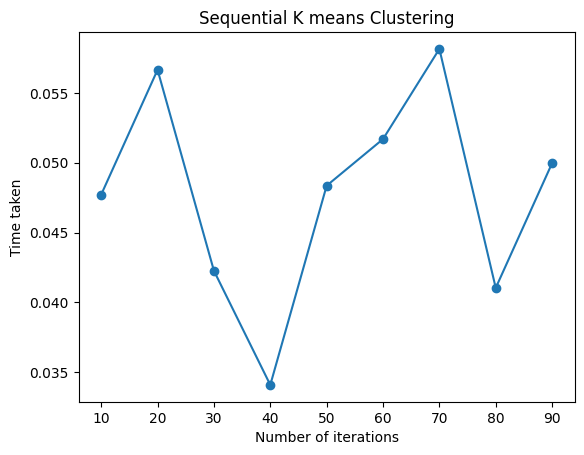

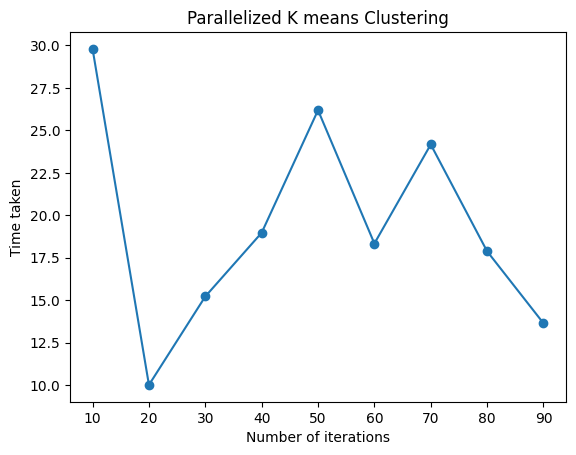

In [ ]:
import time
import matplotlib.pyplot as plt

# Assuming X and itr are defined
X = data.to_numpy()
itr = np.arange(10, 100, 10)
t_ser = []
t_par = []

# Example usage:
# k_medoids = K_Medoids(n_clusters=3, max_iter=100)
# k_medoids.fit(data)
# predicted_labels = k_medoids.predict(data)

# Serial version
for i in itr:
  t1 = time.time()
  KmeansSer = K_Means(3,i)
  y = KmeansSer.fit(X)
  t2 = time.time() - t1
  t_ser.append(t2)



# spark_k_medoids = K_Medoids_parallel(n_clusters=3, max_iter=100, num_cores=4)
# spark_k_medoids.fit(data)
# predicted_labels = spark_k_medoids.predict(data)

# Parallelized version
rdd = sc.parallelize(X)

for i in itr:
  t1 = time.time()
  new_centro, assigned_clusters, convergence_iter = custom_kmeans(n_clusters = 3,data=rdd, maxIter=i)
  t2 = time.time() - t1
  t_par.append(t2)

plt.plot(itr,t_ser,'-o')
plt.title('Sequential K means Clustering')
plt.xlabel('Number of iterations')
plt.ylabel('Time taken')
plt.show()

plt.plot(itr,t_par,'-o')
plt.title('Parallelized K means Clustering')
plt.xlabel('Number of iterations')
plt.ylabel('Time taken')
plt.show()

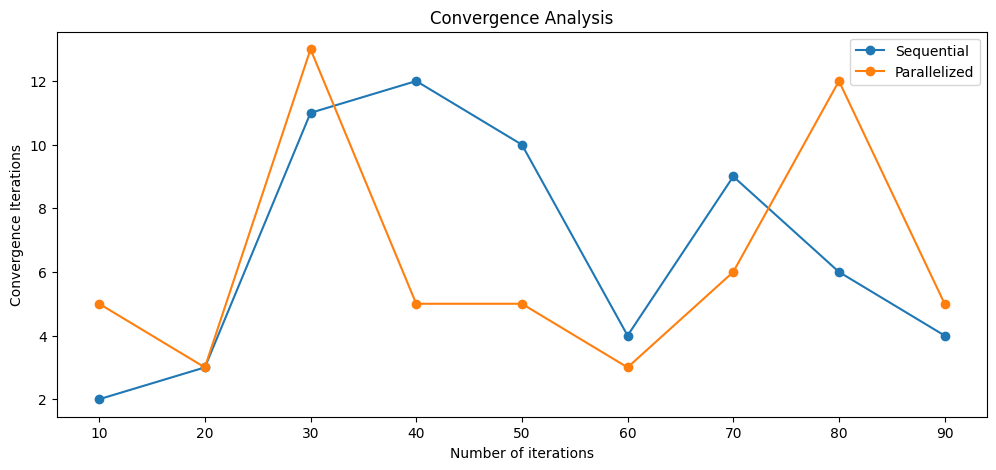

In [ ]:
converged_ser = [K_Means(4, i).fit(X).number_of_iter for i in itr]
converged_par = [custom_kmeans(n_clusters=4, data=rdd, maxIter=i)[2] for i in itr]

plt.figure(figsize=(12, 5))
plt.plot(itr, converged_ser, '-o', label="Sequential")
plt.plot(itr, converged_par, '-o', label="Parallelized")
plt.title('Convergence Analysis')
plt.xlabel('Number of iterations')
plt.ylabel('Convergence Iterations')
plt.legend()
plt.show()

In [ ]:
# Your existing code
X = data.to_numpy()

# Sequential version
t1 = time.time()
KmeansSer = K_Means(3,2500)
y = KmeansSer.fit(X)
t2 = time.time() - t1
data['Label_Seq'] = y.labels_

# Parallelized version
t3 = time.time()
rdd = sc.parallelize(X)
new_centro, assigned_clusters, convergence_iter = custom_kmeans(n_clusters = 3,data=rdd, maxIter=2500)
t4 = time.time() - t3
data['Label_Par'] = assigned_clusters.collect()

# Print the time taken for both versions
print("Sequential Time:", t2)
print("Parallelized Time:", t4)

Sequential Time: 0.05368494987487793
Parallelized Time: 7.33416748046875


In [ ]:
from sklearn import metrics

print("Performance of Sequential algorithm : ",metrics.silhouette_score(X,data['Label_Seq']))
print("Performance of Parallel algorithm : ",metrics.silhouette_score(X,data['Label_Par']))

Performance of Sequential algorithm :  0.6548902543985035
Performance of Parallel algorithm :  0.6548902543985035
